In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import glob
import re
import os

from llm_ran.llm import models
from llm_ran.benchmark.questions import TEST_CASES
from llm_ran.benchmark.helpers import parse_cpu_mi, parse_mem_mi

QUESTIONS_META = {
    (test_case.scenario, question.id): question
    for test_case in TEST_CASES
    for question in test_case.questions
}


productcatalogservice-7476c969c8-5z2sn None


In [2]:
DATA_PATH = "../data"
files = glob.glob(f"{DATA_PATH}/*.csv")
_dfs = []
for file in files:
    _df = pd.read_csv(file)
    _df['file'] = os.path.basename(file)
    _dfs.append(_df)

df = pd.concat(_dfs, ignore_index=True)
# display(df.head())
display(df.columns)

# Clean up paths
df['snapshot_path'] = df['snapshot_path'].str.replace(re.compile(r".*llm-ran"), ".", regex=True)
df['snapshot_path'] = df['snapshot_path'].str.replace('\\', "/")

# Find missing runs
with pd.option_context('display.max_rows', None):
    display(df.groupby(['model', 'scenario', 'chain'])['question'].count().reset_index())


Index(['scenario', 'question', 'trial', 'run_id', 'model', 'chain',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file'],
      dtype='object')

,model,scenario,chain,question
0,llama3.3:70b,base,codegen,360
1,llama3.3:70b,base,direct,360
2,llama3.3:70b,image-not-found,codegen,170
3,llama3.3:70b,image-not-found,direct,170
4,llama3.3:70b,liveness-probe,codegen,150
5,llama3.3:70b,liveness-probe,direct,150
6,llama3.3:70b,node-affinity,codegen,150
7,llama3.3:70b,node-affinity,direct,150
8,llama3.3:70b,resource-constraint,codegen,210
9,llama3.3:70b,resource-constraint,direct,210


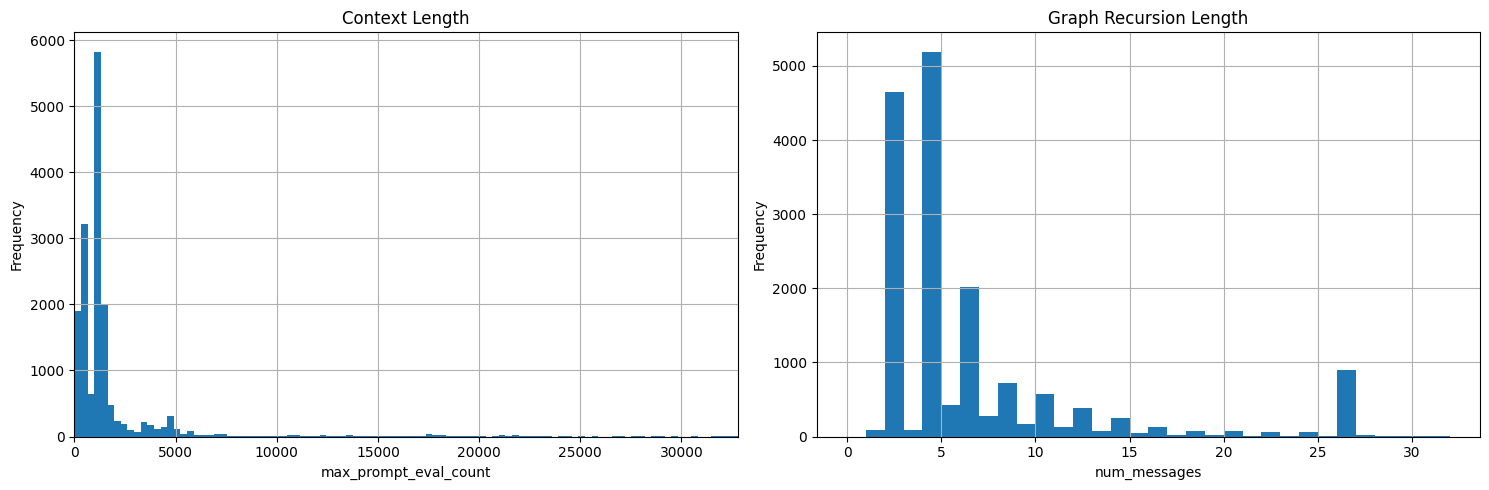

In [3]:
# Parameter selection analysis

# plot eval_count and num_messages
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# ax[0].set_yscale('log')
ax[0].hist(df['max_prompt_eval_count'], bins=100, range=(0, 32768))
ax[0].set_xlabel('max_prompt_eval_count')
ax[0].set_xlim(0, 32768)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Context Length')
ax[0].grid()
# ax[1].set_yscale('log')
ax[1].hist(df['num_messages'], bins=32, range=(0, 32))
ax[1].set_xlabel('num_messages')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Graph Recursion Length')
ax[1].grid()
plt.tight_layout()
plt.show()


In [4]:
match_thought = re.compile(r"(?s)<think>\n(.*)</think>\s*(.*)\s*")
qwq_index = df['model'] == models.QWQ
qwq_frame = df[qwq_index].copy()
qwq_frame[['thought', 'answer']] = qwq_frame['result'].str.extract(match_thought, expand=True)
qwq_frame.to_csv(f"{DATA_PATH}/intermediate/qwq.csv")
df_without_thought = df.copy()
df_without_thought.loc[qwq_index, 'result'] = qwq_frame['answer']

In [5]:
evaluate_as = {}
evaluate_as_outputs = {}
# seperate into different evaluate_as types
for evaluate_type in df_without_thought['evaluate_as'].unique():
    subset = df_without_thought[df_without_thought['evaluate_as'] == evaluate_type]
    evaluate_as[evaluate_type] = subset
len(evaluate_as)

3

In [6]:
# Parse choice questions
choice_questions = evaluate_as[1].copy()
choice_results = choice_questions['result'].str.strip().str.strip('.')
choice_valid = choice_results.str.len() == 1

before_nan = choice_questions['result'].isna()
after_nan = choice_results.str.len() != 1   # can_answer
print('can_answer\t', 1-after_nan.mean())
new_nans = choice_questions[after_nan & ~before_nan]
# new_nans.groupby(['scenario', 'question']).count()['trial'].reset_index().sort_values(by='trial', ascending=False)
# new_nans['result'].to_csv(f"{DATA_PATH}/intermediate/choice_nans.csv")

choice_questions['can_answer'] = choice_valid

patterns = [
    re.compile(r"(?s)([A-E])[\n:\}]"),
    re.compile(r"(?s)[\n\s:\{]([A-E])"),
]

# Parse results
def parse_choice_result(result):
    if pd.isna(result):
        return None
    if len(result) <= 1:
        return result
    for pattern in patterns:
        match = pattern.search(result)
        if match:
            return match.group(1)
    if result[0].isupper() and result[0] in 'ABCDE':
        return result[0]
    if result[-1].isupper() and result[-1] in 'ABCDE':
        return result[-1]
    return None

parsed_choice_results = choice_results.apply(parse_choice_result)
print('parsed_valid\t', (parsed_choice_results.str.len() == 1).mean())
after_nan = parsed_choice_results.isna()
new_nans = choice_questions[after_nan & ~before_nan]
evaluate_as[1][after_nan & ~before_nan].to_csv(f"{DATA_PATH}/intermediate/choice_nans.csv")

new_nans.groupby(['scenario', 'question']).count()['trial'].reset_index().sort_values(by='trial', ascending=False)
choice_questions['result'] = parsed_choice_results
choice_questions['correct'] = choice_questions['result'] == choice_questions['expected']
choice_questions.to_csv(f"{DATA_PATH}/processed/choice.csv")
evaluate_as_outputs[1] = choice_questions.copy()
print('correct\t\t', choice_questions['correct'].mean())
display(choice_questions.loc[
    (choice_questions['correct'] == False)
    & (choice_questions['result'].str.len() == 1),
    'result'
].unique())

can_answer	 0.5848484848484848
parsed_valid	 0.8762121212121212
correct		 0.4760606060606061


array(['B', 'A', 'C', 'D', 'E', 'F', 'G', 'J', 'K', 'N', 'R', 'M', 'Q',
       'S', '5'], dtype=object)

In [7]:
# parse numerical questions

numerical_questions = evaluate_as[0].copy()
before_nan = numerical_questions['result'].isna()

numerical_questions['result'] = numerical_questions['result'].str.strip()

def output_unit(row):
    return QUESTIONS_META.get((row['scenario'], row['question'])).output_unit if QUESTIONS_META.get((row['scenario'], row['question'])) else None

def wrap_df_apply(func):
    def wrapper(result):
        if pd.isna(result):
            return None
        try:
            return func(result)
        except ValueError:
            pass
        try:
            return float(result)
        except ValueError:
            return None
    return wrapper

def apply_patterns(result, patterns):
    if pd.isna(result):
        return None
    for pattern in patterns:
        match = pattern.search(result)
        if match:
            return match.group(1)
    return None

parse_cpu_result = wrap_df_apply(parse_cpu_mi)
parse_mem_result = wrap_df_apply(parse_mem_mi)
output_units = numerical_questions.apply(output_unit, axis=1)

mem_questions = numerical_questions[output_units == 'mem_mi'].copy()
mem_questions['expected'] = mem_questions['expected'].apply(parse_mem_result)
tol_expected = mem_questions['expected'] / 1024
mem_result = mem_questions['result'].apply(parse_mem_result)
numerical_questions.loc[mem_questions.index, 'can_answer'] = mem_result.notna()
invalid_mem = mem_questions.loc[mem_result.isna(), 'result']
parsed_invalid_mem = invalid_mem.apply(apply_patterns, patterns=[
    re.compile(r"answer is:?\s*\**`?(\d+(Ki|Mi|Gi)?)`?\**"),
    re.compile(r"answer to your question is:?\s*\**`?(\d+(Ki|Mi|Gi)?)`?\**"),
    re.compile(r"\n\**`?(\d+(Ki|Mi|Gi)?)`?\**"),
    re.compile(r"=\s*\**`?(\d+(Ki|Mi|Gi)?)`?\**"),
    re.compile(r"is:?\s*\**`?(\d+(Ki|Mi|Gi)?)`?\**"),
    re.compile(r"\boxed{\s*(\d+(Ki|Mi|Gi)?)\s*}"),
])
parsed_invalid_mem = parsed_invalid_mem.apply(parse_mem_result)
mem_result.loc[mem_result.isna()] = parsed_invalid_mem
mem_questions['deviation'] = np.minimum(
    (mem_result - mem_questions['expected']).abs(),
    (mem_result - tol_expected).abs())
mem_questions['result'] = mem_result
numerical_questions.loc[mem_questions.index, 'result'] = mem_questions['result']
numerical_questions.loc[mem_questions.index, 'expected'] = mem_questions['expected']
numerical_questions.loc[mem_questions.index, 'deviation'] = mem_questions['deviation']

cpu_questions = numerical_questions[output_units == 'cpu_m'].copy()
cpu_questions['expected'] = cpu_questions['expected'].apply(parse_cpu_result)
tol_expected = cpu_questions['expected'] / 1000
cpu_result = cpu_questions['result'].apply(parse_cpu_result)
numerical_questions.loc[cpu_questions.index, 'can_answer'] = cpu_result.notna()
invalid_cpu = cpu_questions.loc[cpu_result.isna(), 'result']
parsed_invalid_cpu = invalid_cpu.apply(apply_patterns, patterns=[
    re.compile(r"answer is:?\s*\**`?(\d+(m)?)`?\**"),
    re.compile(r"answer to your question is:?\s*\**`?(\d+(m)?)`?\**"),
    re.compile(r"\n\**`?(\d+(m)?)`?\**"),
    re.compile(r"=\s*\**`?(\d+(m)?)`?\**"),
    re.compile(r"is:?\s*\**`?(\d+(m)?)`?\**"),
    re.compile(r"\boxed{\s*(\d+(m)?)\s*}"),
])
parsed_invalid_cpu = parsed_invalid_cpu.apply(parse_cpu_result)
cpu_result.loc[cpu_result.isna()] = parsed_invalid_cpu
cpu_questions['result'] = cpu_result
cpu_questions['deviation'] = np.minimum(
    (cpu_result - cpu_questions['expected']).abs(),
    (cpu_result - tol_expected).abs())
numerical_questions.loc[cpu_questions.index, 'result'] = cpu_result
numerical_questions.loc[cpu_questions.index, 'expected'] = cpu_questions['expected']
numerical_questions.loc[cpu_questions.index, 'deviation'] = cpu_questions['deviation']

other_questions = numerical_questions[output_units.isna()].copy()
other_result = pd.to_numeric(other_questions['result'], errors='coerce')
other_questions['expected'] = pd.to_numeric(other_questions['expected'], errors='coerce')
numerical_questions.loc[other_questions.index, 'can_answer'] = other_result.notna()
invalid_other = other_questions.loc[other_result.isna(), 'result']
parsed_invalid_other = invalid_other.apply(apply_patterns, patterns=[
    re.compile(r"answer is:?\s*\**`?(\d+)`?\**"),
    re.compile(r"answer to your question is:?\s*\**`?(\d+)`?\**"),
    re.compile(r"\n\**`?(\d+)`?\**"),
    re.compile(r"=\s*\**`?(\d+)`?\**"),
    re.compile(r"is:?\s*\**`?(\d+)`?\**"),
    re.compile(r"\boxed{\s*(\d+)\s*}"),
])
parsed_invalid_other = parsed_invalid_other.apply(pd.to_numeric, errors='coerce')
other_result.loc[other_result.isna()] = parsed_invalid_other
other_questions['deviation'] = (other_result - other_questions['expected']).abs()
numerical_questions.loc[other_questions.index, 'result'] = other_result
numerical_questions.loc[other_questions.index, 'expected'] = other_questions['expected']
numerical_questions.loc[other_questions.index, 'deviation'] = other_questions['deviation']

print('can_answer\t', numerical_questions['can_answer'].mean())

after_nan = numerical_questions['result'].isna()
print('parsed_valid\t', 1-after_nan.mean())
new_nans = numerical_questions[after_nan & ~before_nan]
# new_nans.groupby(['scenario', 'question']).count()['trial'].reset_index().sort_values(by='trial', ascending=False)
evaluate_as[0][after_nan & ~before_nan].to_csv(f"{DATA_PATH}/intermediate/numerical_nans.csv")

with np.errstate(invalid='ignore'):
    numerical_questions['correct'] = numerical_questions['deviation'] <= 0.01 * numerical_questions['expected']
print('correct\t\t', numerical_questions['correct'].mean())
print('msre\t\t', numerical_questions['deviation'].mean())
numerical_questions.to_csv(f"{DATA_PATH}/processed/numerical.csv")
evaluate_as_outputs[0] = numerical_questions.copy()

can_answer	 0.535
parsed_valid	 0.6841666666666666
correct		 0.3988888888888889
msre		 755624257.5866063


In [ ]:
pd.concat(frame for frame in evaluate_as_outputs.values()).to_csv(f"{DATA_PATH}/processed/combined.csv")